In [7]:
pip install pandas wordcloud matplotlib seaborn sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

   index        id                            title   type  \
0      0   tm84618                      Taxi Driver  MOVIE   
1      1  tm127384  Monty Python and the Holy Grail  MOVIE   
2      2   tm70993                    Life of Brian  MOVIE   
3      3  tm190788                     The Exorcist  MOVIE   
5      5   tm14873                      Dirty Harry  MOVIE   

                                         description  release_year  \
0  A mentally unstable Vietnam War veteran works ...          1976   
1  King Arthur, accompanied by his squire, recrui...          1975   
2  Brian Cohen is an average young Jewish man, bu...          1979   
3  12-year-old Regan MacNeil begins to adapt an e...          1973   
5  When a madman dubbed 'Scorpio' terrorizes San ...          1971   

  age_certification  runtime    imdb_id  imdb_score  imdb_votes  
0                 R      113  tt0075314         8.3    795222.0  
1                PG       91  tt0071853         8.2    530877.0  
2       

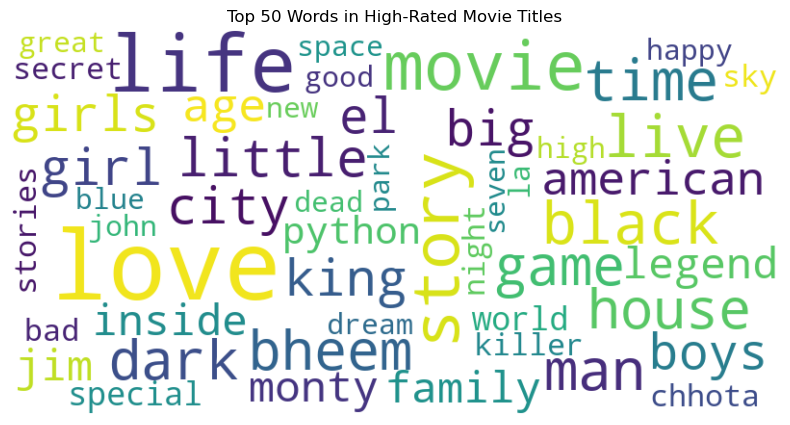

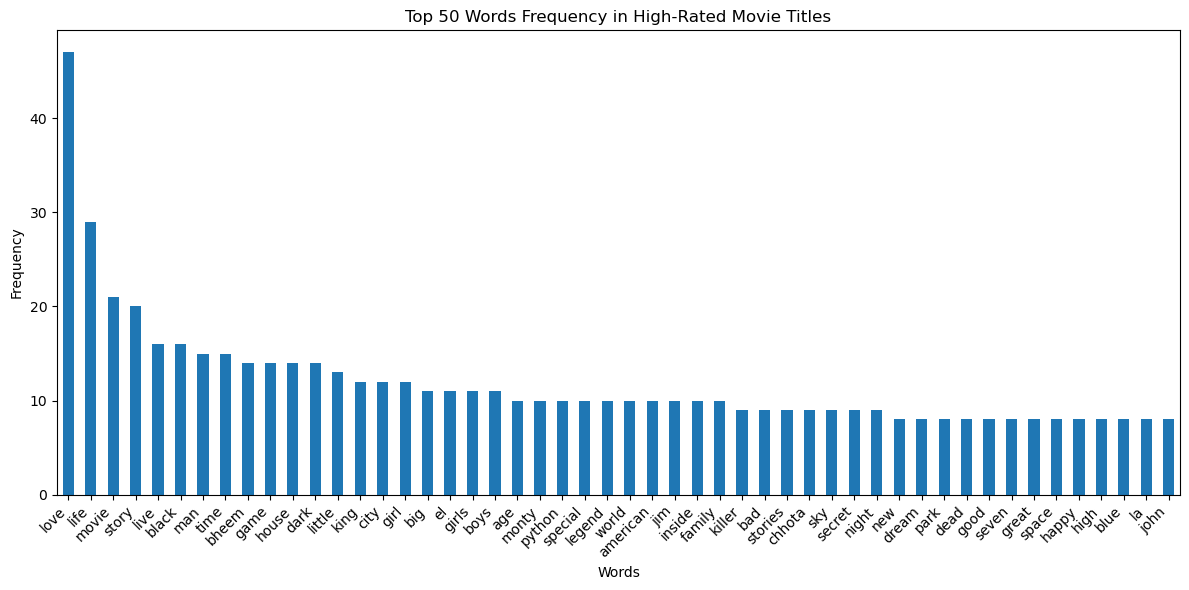

Pearson Correlation between Word Frequency and Average Score: -0.09


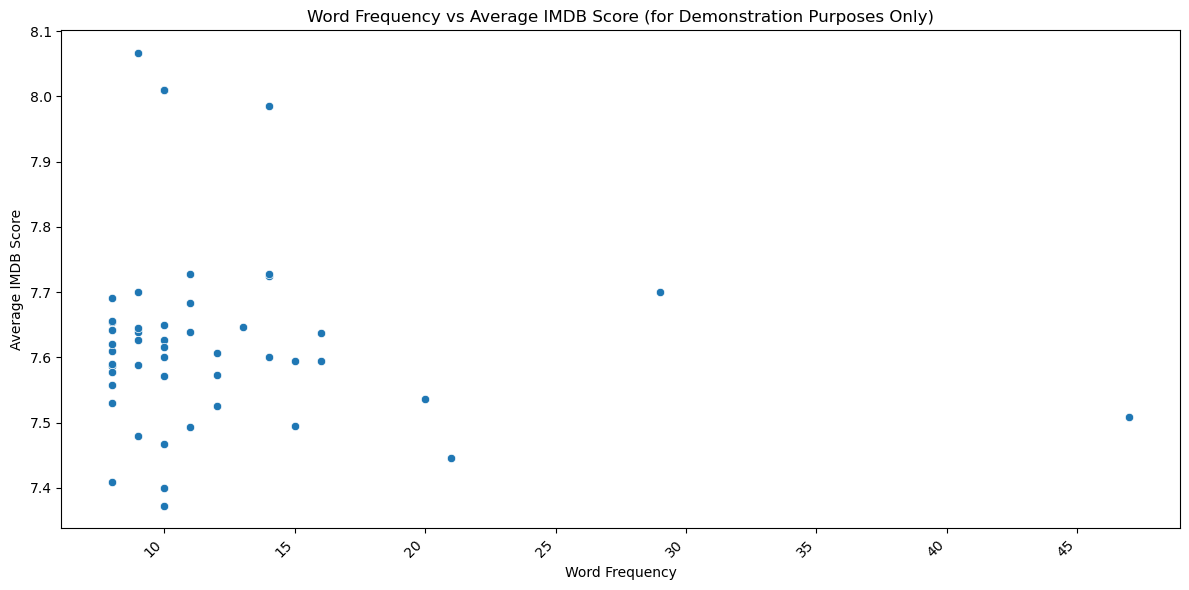

In [1]:
#文本类分析内容
#分析高评分电影的标题（title），提取出常见的高频词或关键词
#构建前50个词频的词云图和柱状图

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import numpy as np

# 读取CSV文件
df = pd.read_csv('https://raw.githubusercontent.com/hkusda7005group10/groupdata/refs/heads/main/7005groupdata.csv')  

movies_df = df[df['type'] == 'MOVIE']
print(movies_df.head())

# 过滤出高评分电影（暂无条件）
high_rated_movies = df[df['imdb_score' ] >= 7]

# 提取高评分电影的标题
titles = high_rated_movies['title'].astype(str).tolist()

# 使用CountVectorizer提取词频
vectorizer = CountVectorizer(stop_words='english', max_features=50)
X = vectorizer.fit_transform(titles)

# 获取词频矩阵
feature_names = vectorizer.get_feature_names_out()
word_freq = X.toarray().sum(axis=0)

# 构建词频字典
word_freq_dict = dict(zip(feature_names, word_freq))

# 生成词云图
wordcloud = WordCloud(width=800, height=400, background_color='white', max_font_size=100, max_words=50).generate_from_frequencies(word_freq_dict)

# 显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Words in High-Rated Movie Titles')
plt.show()

# 构建柱状图
word_freq_series = pd.Series(word_freq, index=feature_names)
word_freq_series.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
word_freq_series.plot(kind='bar')
plt.title('Top 50 Words Frequency in High-Rated Movie Titles')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 分析高频词与评分的关系
# 为了进行相关性分析，我们需要将文本数据转换为数值数据
# 直接使用词频作为特征
# 然后对于每个词，计算包含该词的电影的平均评分

word_scores = {}
for word in feature_names:
    movies_with_word = high_rated_movies[high_rated_movies['title'].str.contains(word, case=False, na=False)]
    if not movies_with_word.empty:
        word_scores[word] = movies_with_word['imdb_score'].mean()

# 将词频和平均评分转换为DataFrame以便分析
word_data = pd.DataFrame.from_dict(word_scores, orient='index', columns=['Average Score'])
word_data['Word Frequency'] = word_freq

# 注意：这里的相关性分析可能不够准确，因为词频和评分之间的关系可能是非线性的，并且受到其他因素的影响
# 但为了演示目的，我们还是计算一下它们之间的皮尔逊相关系数
correlation = word_data['Word Frequency'].corr(word_data['Average Score'])
print(f'Pearson Correlation between Word Frequency and Average Score: {correlation:.2f}')

# 最后，我们可以简单地可视化一下词频和平均评分的关系（虽然这可能不是很有意义，因为我们已经知道它们之间的相关性可能不高）
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Word Frequency', y='Average Score', data=word_data)
plt.title('Word Frequency vs Average IMDB Score (for Demonstration Purposes Only)')
plt.xlabel('Word Frequency')
plt.ylabel('Average IMDB Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 请注意，上面的散点图和相关性分析只是为了演示目的，并不一定能得出有意义的结论
# 在实际应用中，可能需要使用更复杂的分析方法和模型来探索词频和评分之间的关系

Average IMDB score for movies with "love" in the title: 6.59
Average IMDB score for all movies: 6.53
T-statistic: 0.69, P-value: 0.4938
There is no statistically significant difference between the IMDB scores of movies with and without "love" in the title.


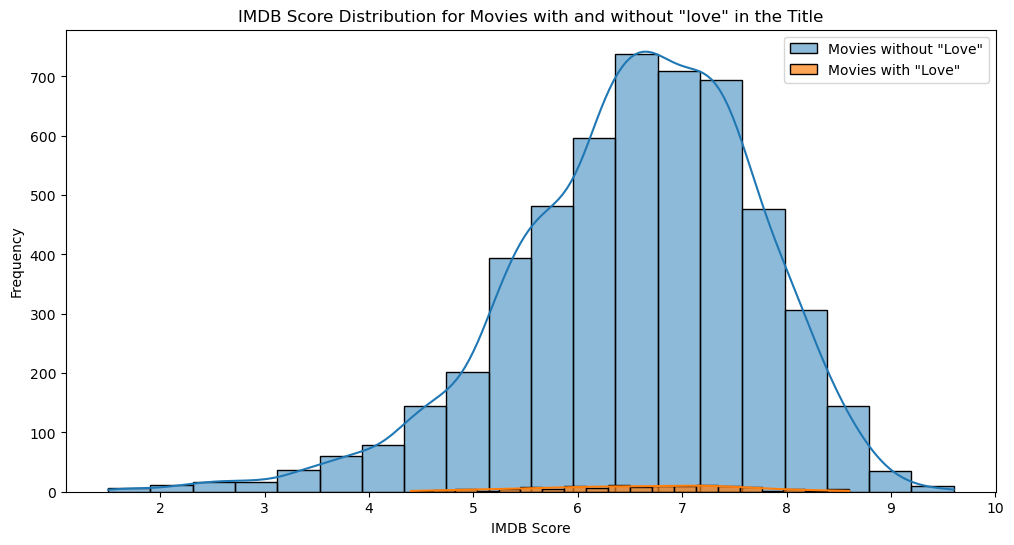

In [2]:
#和评分（imdb_score）进行分析，看看哪些具体的词有助于高评分的形成。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取CSV文件并洗出只需要movie
df = pd.read_csv('https://raw.githubusercontent.com/hkusda7005group10/groupdata/refs/heads/main/7005groupdata.csv')  

movies_df = df[df['type'] == 'MOVIE']

# 定义要分析的具体词
target_word = 'love'

# 创建一个新列来标记标题中是否包含目标词
df['contains_target_word'] = df['title'].str.contains(target_word, case=False, na=False)

# 过滤出包含目标词的电影
movies_with_target_word = df[df['contains_target_word']]

# 计算包含目标词的电影的平均评分
average_score_with_target_word = movies_with_target_word['imdb_score'].mean()

# 计算所有电影的平均评分作为对比
average_score_all_movies = df['imdb_score'].mean()

# 输出结果
print(f'Average IMDB score for movies with "{target_word}" in the title: {average_score_with_target_word:.2f}')
print(f'Average IMDB score for all movies: {average_score_all_movies:.2f}')

# 使用t检验来比较两组评分的均值是否存在显著差异
# 注意：这里假设评分数据是正态分布的，且两组样本是独立的
t_stat, p_value = stats.ttest_ind(
    movies_with_target_word['imdb_score'],
    df[~df['contains_target_word']]['imdb_score'],
    equal_var=False  # 由于样本量可能不同，这里使用Welch's t-test
)

print(f'T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}')

# 如果p值小于显著性水平（例如0.05），则拒绝原假设，认为两组评分存在显著差异
significance_level = 0.05
if p_value < significance_level:
    print(f'There is a statistically significant difference between the IMDB scores of movies with and without "{target_word}" in the title.')
else:
    print(f'There is no statistically significant difference between the IMDB scores of movies with and without "{target_word}" in the title.')

# 可视化评分分布（可选）
plt.figure(figsize=(12, 6))
sns.histplot(df[~df['contains_target_word']]['imdb_score'], bins=20, label='Movies without "Love"', kde=True)
sns.histplot(movies_with_target_word['imdb_score'], bins=20, label='Movies with "Love"', kde=True, alpha=0.7)
plt.title(f'IMDB Score Distribution for Movies with and without "{target_word}" in the Title')
plt.xlabel('IMDB Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Average IMDB score for movies with "life" in the title: 6.84
Average IMDB score for all movies: 6.53
T-statistic: 2.28, P-value: 0.0261
There is a statistically significant difference between the IMDB scores of movies with and without "life" in the title.


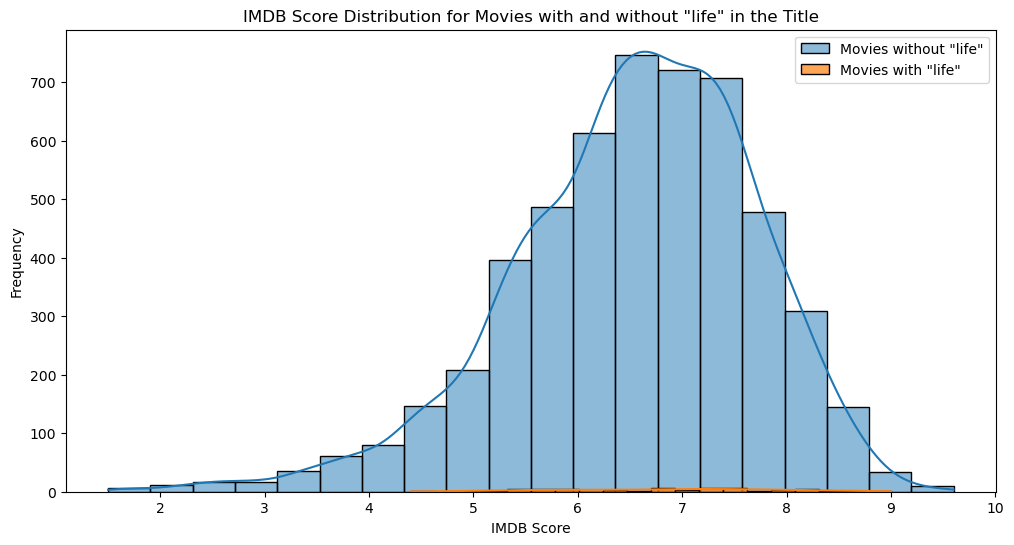

In [3]:
#和评分（imdb_score）进行分析，看看哪些具体的词有助于高评分的形成。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取CSV文件并洗出movie
df = pd.read_csv('https://raw.githubusercontent.com/hkusda7005group10/groupdata/refs/heads/main/7005groupdata.csv')  
movies_df = df[df['type'] == 'MOVIE']

# 定义要分析的具体词
target_word = 'life'

# 创建一个新列来标记标题中是否包含目标词
df['contains_target_word'] = df['title'].str.contains(target_word, case=False, na=False)

# 过滤出包含目标词的电影
movies_with_target_word = df[df['contains_target_word']]

# 计算包含目标词的电影的平均评分
average_score_with_target_word = movies_with_target_word['imdb_score'].mean()

# 计算所有电影的平均评分作为对比
average_score_all_movies = df['imdb_score'].mean()

# 输出结果
print(f'Average IMDB score for movies with "{target_word}" in the title: {average_score_with_target_word:.2f}')
print(f'Average IMDB score for all movies: {average_score_all_movies:.2f}')

# 使用t检验来比较两组评分的均值是否存在显著差异
# 注意：这里假设评分数据是正态分布的，且两组样本是独立的
t_stat, p_value = stats.ttest_ind(
    movies_with_target_word['imdb_score'],
    df[~df['contains_target_word']]['imdb_score'],
    equal_var=False  # 由于样本量可能不同，这里使用Welch's t-test
)

print(f'T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}')

# 如果p值小于显著性水平（例如0.05），则拒绝原假设，认为两组评分存在显著差异
significance_level = 0.05
if p_value < significance_level:
    print(f'There is a statistically significant difference between the IMDB scores of movies with and without "{target_word}" in the title.')
else:
    print(f'There is no statistically significant difference between the IMDB scores of movies with and without "{target_word}" in the title.')

# 可视化评分分布（可选）
plt.figure(figsize=(12, 6))
sns.histplot(df[~df['contains_target_word']]['imdb_score'], bins=20, label='Movies without "life"', kde=True)
sns.histplot(movies_with_target_word['imdb_score'], bins=20, label='Movies with "life"', kde=True, alpha=0.7)
plt.title(f'IMDB Score Distribution for Movies with and without "{target_word}" in the Title')
plt.xlabel('IMDB Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [11]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


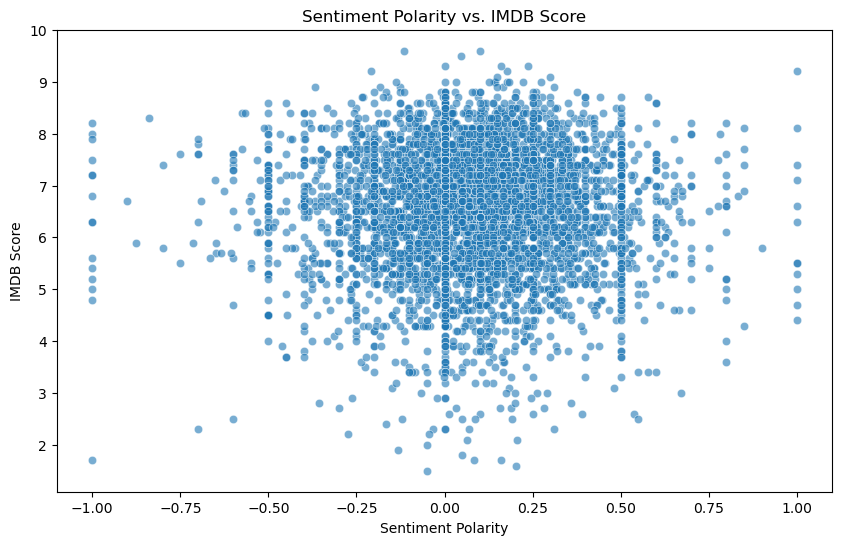

Correlation between sentiment polarity and IMDB score: 0.01
Pearson correlation coefficient: 0.01, P-value: 0.5833
There is no statistically significant correlation between sentiment polarity and IMDB score.


In [4]:
# 电影描述的情感倾向分析：
# 分析高评分电影的描述（description）的情感倾向，看看这些电影的描述是否普遍带有积极情感，是否与评分（imdb_score）之间存在关联？

import pandas as pd
import textblob
from textblob import TextBlob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 读取CSV文件
df = pd.read_csv('https://raw.githubusercontent.com/hkusda7005group10/groupdata/refs/heads/main/7005groupdata.csv') 
movies_df = df[df['type'] == 'MOVIE']

#清洗description的非字符串内容
df['description'] = df['description'].astype(str)

# 定义一个函数来计算文本的情感极性
def calculate_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# 应用该函数到电影的描述列上，创建一个新列来存储情感极性
df['sentiment_polarity'] = df['description'].apply(calculate_sentiment)

# 可视化情感极性与评分之间的关系（散点图）
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_polarity', y='imdb_score', data=df, alpha=0.6)
plt.title('Sentiment Polarity vs. IMDB Score')
plt.xlabel('Sentiment Polarity')
plt.ylabel('IMDB Score')
plt.show()

# 计算情感极性与评分之间的相关系数
correlation_coefficient = df['sentiment_polarity'].corr(df['imdb_score'])
print(f'Correlation between sentiment polarity and IMDB score: {correlation_coefficient:.2f}')

# 使用皮尔逊相关系数检验来检验相关性是否显著
# 注意：这里假设评分和情感极性数据都是连续变量，并且样本量足够大
pearson_corr, p_value = stats.pearsonr(df['sentiment_polarity'], df['imdb_score'])
print(f'Pearson correlation coefficient: {pearson_corr:.2f}, P-value: {p_value:.4f}')

# 如果p值小于显著性水平（例如0.05），则认为相关性是显著的
significance_level = 0.05
if p_value < significance_level:
    print(f'There is a statistically significant correlation between sentiment polarity and IMDB score.')
else:
    print(f'There is no statistically significant correlation between sentiment polarity and IMDB score.')

In [5]:
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# 确保已经下载了nltk的stopwords和punkt数据包
nltk.download('stopwords')
nltk.download('punkt')

# 读取CSV文件
df = pd.read_csv('https://raw.githubusercontent.com/hkusda7005group10/groupdata/refs/heads/main/7005groupdata.csv') 
movies_df = df[df['type'] == 'MOVIE']
df['description'] = df['description'].astype(str)

# 筛选出高评分电影（例如IMDb评分大于7的电影）
high_rated_movies = df[df['imdb_score'] >= 7]

# 文本预处理函数
def preprocess_text(text):
    text = text.lower()  # 转换为小写
    text = re.sub(r'[^a-z\s]', '', text)  # 去除标点符号和数字
    words = word_tokenize(text)  # 分词
    stop_words = set(stopwords.words('english'))  # 获取停用词列表
    words = [word for word in words if word not in stop_words]  # 去除停用词
    return words

# 对高评分电影的描述进行预处理
processed_descriptions = high_rated_movies['description'].apply(preprocess_text)

# 合并所有描述为一个长列表，以便进行词频分析
all_words = [word for desc in processed_descriptions for word in desc]

# 计算词频
word_counts = Counter(all_words)

# 打印高频词汇
print("Top 50 most frequent words:")
print(word_counts.most_common(50))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cute_bear_zjj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/cute_bear_zjj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top 50 most frequent words:
[('life', 353), ('world', 244), ('one', 218), ('new', 209), ('family', 200), ('love', 195), ('story', 194), ('young', 192), ('years', 178), ('two', 176), ('series', 162), ('man', 141), ('lives', 140), ('school', 135), ('friends', 132), ('find', 113), ('time', 104), ('people', 102), ('first', 99), ('home', 95), ('father', 93), ('become', 89), ('woman', 89), ('special', 89), ('war', 88), ('way', 87), ('back', 87), ('three', 85), ('takes', 84), ('together', 83), ('take', 82), ('set', 82), ('comedy', 79), ('documentary', 79), ('must', 78), ('get', 77), ('city', 76), ('best', 76), ('journey', 76), ('show', 74), ('film', 74), ('stories', 74), ('group', 74), ('high', 73), ('true', 73), ('help', 73), ('finds', 72), ('girl', 71), ('follows', 71), ('death', 70)]


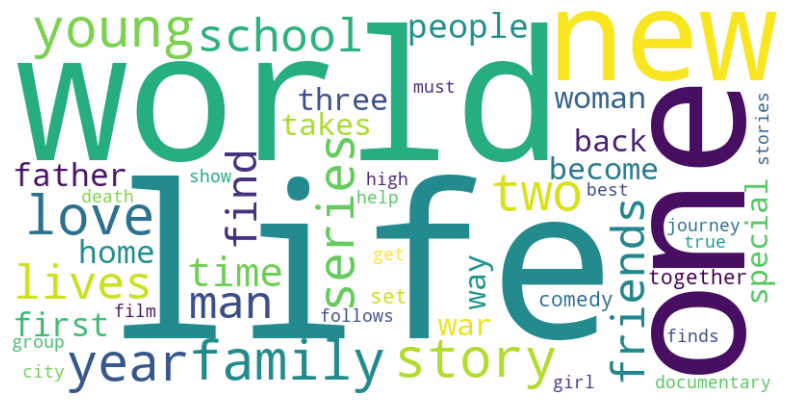

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 假设你有一个包含词频的字典，例如：
word_freq = {
    'life':  353, 
    'world': 244, 
    'one': 218,
    'new': 209, 
    'family': 200, 
    'love': 195,
    'story': 194,
    'young': 192,
    'year': 178,
    'two': 176, 
    'series': 162,
    'man': 141,
    'lives': 140,
    'school': 135,
    'friends': 132,
    'find': 113,
    'time': 104,
    'people': 102,
    'first': 99,
    'home': 95,
    'father': 93,
    'become': 89,
    'woman': 89,
    'special': 89,
    'war': 88,
    'way': 87,
    'back': 87,
    'three': 85,
    'takes': 84,
    'together': 83,
    'set': 82,
    'comedy': 79,
    ' documentary': 79,
    'must': 78,
    'get': 77,
    'city': 76,
    'best': 76,
    'journey': 76,
    'show': 74, 
    'film': 74,
    'stories': 74,
    'group': 74,
    'high': 73,
    'help': 73,
    'true': 73,
    'finds': 72,
    'girl': 71,
    'follows':71,
    'death':70
}

# 创建WordCloud对象，并传入词频数据
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      min_font_size=10).generate_from_frequencies(word_freq)

# 显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
plt.show()

Average IMDB score for movies with "life" in the title: 6.63
Average IMDB score for all movies: 6.53
T-statistic: 2.77, P-value: 0.0057
There is a statistically significant difference between the IMDB scores of movies with and without "life" in the title.


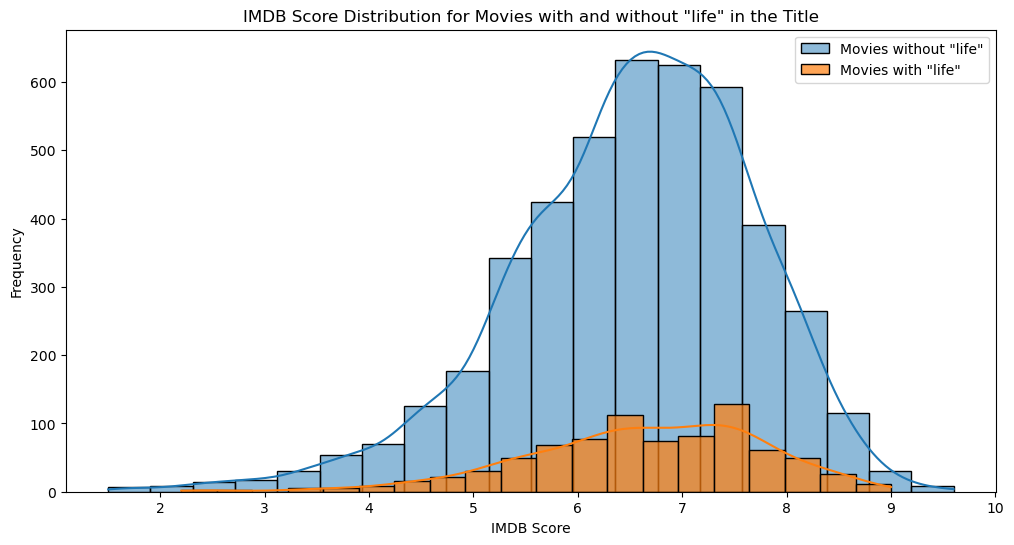

In [7]:
#之后和评分（imdb_score）进行分析，看看哪些具体的词有助于高评分的形成。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取CSV文件
df = pd.read_csv('https://raw.githubusercontent.com/hkusda7005group10/groupdata/refs/heads/main/7005groupdata.csv') 
movies_df = df[df['type'] == 'MOVIE']

# 定义要分析的具体词
target_word = 'life'

# 创建一个新列来标记标题中是否包含目标词
df['contains_target_word'] = df['description'].str.contains(target_word, case=False, na=False)

# 过滤出包含目标词的电影
movies_with_target_word = df[df['contains_target_word']]

# 计算包含目标词的电影的平均评分
average_score_with_target_word = movies_with_target_word['imdb_score'].mean()

# 计算所有电影的平均评分作为对比
average_score_all_movies = df['imdb_score'].mean()

# 输出结果
print(f'Average IMDB score for movies with "{target_word}" in the title: {average_score_with_target_word:.2f}')
print(f'Average IMDB score for all movies: {average_score_all_movies:.2f}')

# 使用t检验来比较两组评分的均值是否存在显著差异
# 注意：这里假设评分数据是正态分布的，且两组样本是独立的
t_stat, p_value = stats.ttest_ind(
    movies_with_target_word['imdb_score'],
    df[~df['contains_target_word']]['imdb_score'],
    equal_var=False  # 由于样本量可能不同，这里使用Welch's t-test
)

print(f'T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}')

# 如果p值小于显著性水平（例如0.05），则拒绝原假设，认为两组评分存在显著差异
significance_level = 0.05
if p_value < significance_level:
    print(f'There is a statistically significant difference between the IMDB scores of movies with and without "{target_word}" in the title.')
else:
    print(f'There is no statistically significant difference between the IMDB scores of movies with and without "{target_word}" in the title.')

# 可视化评分分布（可选）
plt.figure(figsize=(12, 6))
sns.histplot(df[~df['contains_target_word']]['imdb_score'], bins=20, label='Movies without "life"', kde=True)
sns.histplot(movies_with_target_word['imdb_score'], bins=20, label='Movies with "life"', kde=True, alpha=0.7)
plt.title(f'IMDB Score Distribution for Movies with and without "{target_word}" in the Title')
plt.xlabel('IMDB Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Average IMDB score for movies with "world" in the title: 6.67
Average IMDB score for all movies: 6.53
T-statistic: 3.09, P-value: 0.0021
There is a statistically significant difference between the IMDB scores of movies with and without "world" in the title.


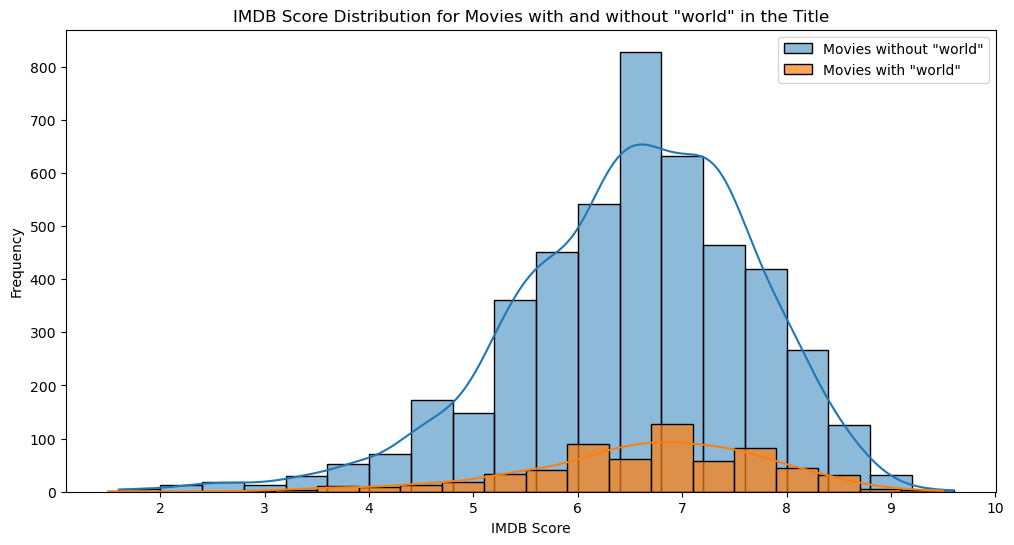

In [8]:
#之后和评分（imdb_score）进行分析，看看哪些具体的词有助于高评分的形成。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取CSV文件
df = pd.read_csv('https://raw.githubusercontent.com/hkusda7005group10/groupdata/refs/heads/main/7005groupdata.csv') 
movies_df = df[df['type'] == 'MOVIE']

# 定义要分析的具体词
target_word = 'world'

# 创建一个新列来标记标题中是否包含目标词
df['contains_target_word'] = df['description'].str.contains(target_word, case=False, na=False)

# 过滤出包含目标词的电影
movies_with_target_word = df[df['contains_target_word']]

# 计算包含目标词的电影的平均评分
average_score_with_target_word = movies_with_target_word['imdb_score'].mean()

# 计算所有电影的平均评分作为对比
average_score_all_movies = df['imdb_score'].mean()

# 输出结果
print(f'Average IMDB score for movies with "{target_word}" in the title: {average_score_with_target_word:.2f}')
print(f'Average IMDB score for all movies: {average_score_all_movies:.2f}')

# 使用t检验来比较两组评分的均值是否存在显著差异
# 注意：这里假设评分数据是正态分布的，且两组样本是独立的
t_stat, p_value = stats.ttest_ind(
    movies_with_target_word['imdb_score'],
    df[~df['contains_target_word']]['imdb_score'],
    equal_var=False  # 由于样本量可能不同，这里使用Welch's t-test
)

print(f'T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}')

# 如果p值小于显著性水平（例如0.05），则拒绝原假设，认为两组评分存在显著差异
significance_level = 0.05
if p_value < significance_level:
    print(f'There is a statistically significant difference between the IMDB scores of movies with and without "{target_word}" in the title.')
else:
    print(f'There is no statistically significant difference between the IMDB scores of movies with and without "{target_word}" in the title.')

# 可视化评分分布（可选）
plt.figure(figsize=(12, 6))
sns.histplot(df[~df['contains_target_word']]['imdb_score'], bins=20, label='Movies without "world"', kde=True)
sns.histplot(movies_with_target_word['imdb_score'], bins=20, label='Movies with "world"', kde=True, alpha=0.7)
plt.title(f'IMDB Score Distribution for Movies with and without "{target_word}" in the Title')
plt.xlabel('IMDB Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Average IMDB score for movies with "family" in the title: 6.42
Average IMDB score for all movies: 6.53
T-statistic: -2.24, P-value: 0.0252
There is a statistically significant difference between the IMDB scores of movies with and without "family" in the title.


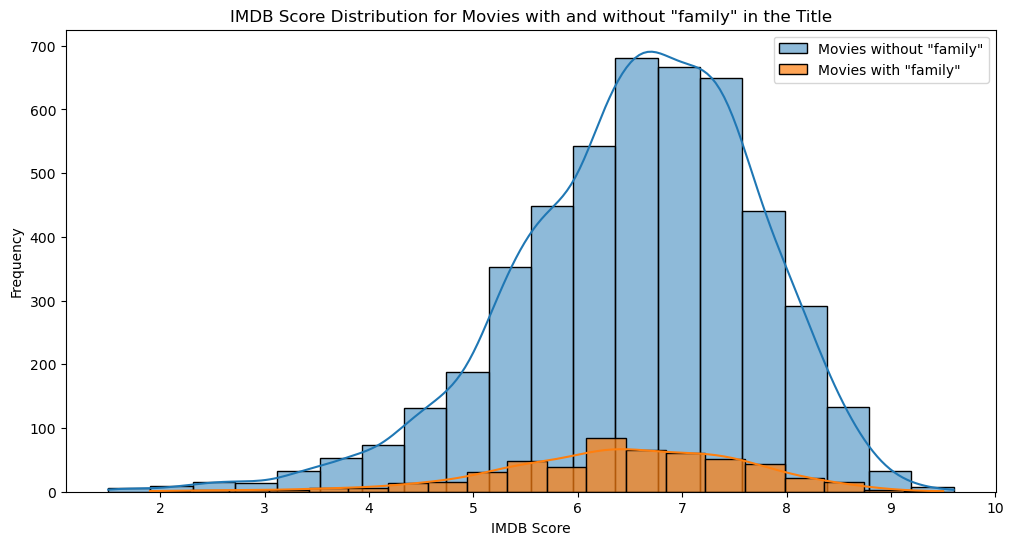

In [10]:
#之后和评分（imdb_score）进行分析，看看哪些具体的词有助于高评分的形成。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取CSV文件
df = pd.read_csv('https://raw.githubusercontent.com/hkusda7005group10/groupdata/refs/heads/main/7005groupdata.csv') 
movies_df = df[df['type'] == 'MOVIE']

# 定义要分析的具体词
target_word = 'family'

# 创建一个新列来标记标题中是否包含目标词
df['contains_target_word'] = df['description'].str.contains(target_word, case=False, na=False)

# 过滤出包含目标词的电影
movies_with_target_word = df[df['contains_target_word']]

# 计算包含目标词的电影的平均评分
average_score_with_target_word = movies_with_target_word['imdb_score'].mean()

# 计算所有电影的平均评分作为对比
average_score_all_movies = df['imdb_score'].mean()

# 输出结果
print(f'Average IMDB score for movies with "{target_word}" in the title: {average_score_with_target_word:.2f}')
print(f'Average IMDB score for all movies: {average_score_all_movies:.2f}')

# 使用t检验来比较两组评分的均值是否存在显著差异
# 注意：这里假设评分数据是正态分布的，且两组样本是独立的
t_stat, p_value = stats.ttest_ind(
    movies_with_target_word['imdb_score'],
    df[~df['contains_target_word']]['imdb_score'],
    equal_var=False  # 由于样本量可能不同，这里使用Welch's t-test
)

print(f'T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}')

# 如果p值小于显著性水平（例如0.05），则拒绝原假设，认为两组评分存在显著差异
significance_level = 0.05
if p_value < significance_level:
    print(f'There is a statistically significant difference between the IMDB scores of movies with and without "{target_word}" in the title.')
else:
    print(f'There is no statistically significant difference between the IMDB scores of movies with and without "{target_word}" in the title.')

# 可视化评分分布（可选）
plt.figure(figsize=(12, 6))
sns.histplot(df[~df['contains_target_word']]['imdb_score'], bins=20, label='Movies without "family"', kde=True)
sns.histplot(movies_with_target_word['imdb_score'], bins=20, label='Movies with "family"', kde=True, alpha=0.7)
plt.title(f'IMDB Score Distribution for Movies with and without "{target_word}" in the Title')
plt.xlabel('IMDB Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()